<a href="https://colab.research.google.com/github/les67/Reinforcement_Learning/blob/main/jlab_1_pendulum_ddpg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Interview Problems for Data Science Postdoc position

## Problem #1 (reinforcement learning)

The goal of this exercise is to solve the inverted pendulum problem using reinforcement learning. The inverted pendulum swing-up problem is a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright. 

To solve this problem, implement the Deep Deterministic Policy Gradient (DDPG) algorithm (https://arxiv.org/pdf/1509.02971.pdf) in a python class and provide a script that coordinates the interaction between the agent and the environment. Please provides figures that capture the learning behavior of the agent. The applicant is expected to use the
Pendulum-v0 environment provided by OpenAI gym. 


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
!pip install pygame # required for Pendulum-v1 env
!pip install gym==0.23.1 # latest version of Gym (03.29.2022)
!pip install gym[classic_control] # dependencies for classic control environments
import gym

!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2 # wrapper around moviepy for rendering video in google colab
!pip install ale-py
from colabgymrender.recorder import Recorder

The inverted pendulum swingup problem is a classic problem in the control literature. The pendulum starts in a random position, and the goal is to swing it up so it stays upright. Table 1 below shows the state space (continuous) and Table 2 the action space (continuous) of pendulum environment where $\theta$ is the pendulum angle with respect to the vertical axis ($\theta\in [-\pi,\pi]$). 

Table 1:

Num  | State            |       Min   |   Max  
-----|------------------|-------------|--------
0    | $\cos(\theta)$   | -1.0        |  1.0
1    | $\sin(\theta)$   | -1.0        |  1.0
2    | $\theta$ dot (i.e $|\theta|^2$)     | -8          |  8


Table 2:

Num  | Action           |       Min   |   Max  
-----|------------------|-------------|--------
0    | Joint Effort  | -2.0        |  2.0

The default reward depends on $\theta$. To get the maximum reward, the angle needs to remain at zero, with the least rotational velocity and the least effort. 

The precise reward functions is $-(\theta^2+0.1(|\theta|^2)^2+0.001\times a^2)$ where $a$ is the action. This reward is normalized between $(-\pi,\pi]$, therefore the lowest reward is approximately -16.27 and the highest reward is 0.

Information from https://github.com/openai/gym/wiki/Pendulum-v1.

In [2]:
# Set environment
env = gym.make('Pendulum-v1')
directory = './video'
env = Recorder(env, directory) # Wrapper to play video, default frame rate at 30 fps

num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
print("Size of State Space is {} and size of action space is {}".format(num_states,num_actions))

Size of State Space is 3 and size of action space is 1


- Video before RL:

In [3]:
new_state = env.reset()
done = False
while not done:
  action = env.action_space.sample()
  new_state, reward, done, _ = env.step(action)

env.play()

100%|█████████▉| 201/202 [00:00<00:00, 344.63it/s]


- I follow the actor and critic models from the original DDPG paper (https://arxiv.org/pdf/1509.02971.pdf) whose NN architectures follow the implementation of https://arxiv.org/pdf/1312.5602.pdf (Atari with Deep Q-Learning). Initialization values follow DDPG paper as specified in the supplemental materials.

In [4]:
# Define actor and critic models with NNs, and policy function

def actor_model(): # input state will be set

  input = layers.Input(shape=(num_states,)) # second tuple entry is left empty for dynamic batch size
  # Initialize layers to [-1/sqrt(f_in),1/sqrt(f_in)] where f_in is the fan in of the layer (number of input units in the weight tensor), DDPG Sec. 7. 
  # Here we use He initilization which is the same except that it is bounded by [-6/sqrt(f_in),6/sqrt(f_in)]
  # "The low-dimensional networks had 2 hidden layers with 400 and 300 units", DDPG Sec. 7
  layer1 = layers.Dense(400, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform())(input)
  layer2 = layers.Dense(300, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform())(layer1)
  # The final layer weights and biases of both the actor and critic were initialized from a uniform distribution [−3 × 10^−3, 3 × 10^−3]
  # This was to ensure the initial outputs for the policy and value estimates were near zero
  output = layers.Dense(1, activation='tanh', kernel_initializer=tf.random_uniform_initializer(minval=-0.003, maxval=0.003))(layer2)
  output = output*2 # rescale to match maximum action value of 2 for pendulum 
  model = tf.keras.Model(input, output)

  return model

def critic_model(): # inputs are (state,action)

  state_input = layers.Input(shape=(num_states))
  state_layer1 = layers.Dense(16, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform())(state_input) # Atari paper Sec 4.1
  state_layer2 = layers.Dense(32, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform())(state_layer1) # Atari paper Sec 4.1
  action_input = layers.Input(shape=(num_actions))
  action_layer2 = layers.Dense(32, activation="relu")(action_input) # "Actions were not included until the 2nd hidden layer of Q", DDPG Sec. 7
  concat_tensor = layers.Concatenate()([state_layer2, action_layer2])
  layer3 = layers.Dense(256, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform())(concat_tensor) # Atari paper Sec 4.1
  layer4 = layers.Dense(256, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform())(layer3)
  output = layers.Dense(1)(layer4)

  # Outputs single value for give state-action
  model = tf.keras.Model([state_input, action_input], output)

  return model  

# Instantiate estimator actor and critic as well as target actor and critic
actor = actor_model()
target_actor = actor_model()
target_actor.set_weights(actor.get_weights())

critic = critic_model()
target_critic = critic_model()
target_critic.set_weights(critic.get_weights())

# Instantiate optimizers
actor_opt = tf.keras.optimizers.Adam(1e-4) # learning rates from DDPG Sec. 7
critic_opt = tf.keras.optimizers.Adam(1e-3)

- As explained in DDPG Sec. 7, the Ornstein-Uhlenbeck process (https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) is used to sample noise which is then added to the sampled actions in order to add temporarily correlated noise. This aids in exploration of states
- The update formula I follow is from the OU wiki page:
$\Delta x = x_{t'} - x_t= \theta(\mu - x_t)dt + \sigma \Delta W_t$ where $W$ is the Weiner process so that $\Delta W = W_{t'}-W_t = \sqrt{t'-t}\times Z$ and $Z$ is an independent standard normal variable (https://en.wikipedia.org/wiki/Wiener_process)

In [5]:
def ou_noise(mean,std,theta=0.15,t_step=1e-3): 

  # theta and std set from DDPG Sec. 7
  # I chose a very small time step (0.001)
  x_t0 = np.zeros_like(mean)
  x_t1 = x_t0 + theta*(mean-x_t0)*t_step + std*np.sqrt(t_step)*np.random.normal(size=mean.shape)

  return x_t1

- Define the policy:

In [6]:
def policy(state, noise):

    sampled_actions = tf.squeeze(actor(state)) # sample action, remove unecessary singular dimensions with squeeze
    sampled_actions = sampled_actions.numpy() + noise # add ou noise to action for exploration
    action = np.clip(sampled_actions, -2.0, 2.0) # action must be within joint effort bounds

    return [np.squeeze(action)]

- Replay Buffers: "All standard algorithms for training a deep neural network to approximate Q^*(s,a) make use of an experience replay buffer. This is the set ${\mathcal D}$ of previous experiences. In order for the algorithm to have stable behavior, the replay buffer should be large enough to contain a wide range of experiences, but it may not always be good to keep everything. If you only use the very-most recent data, you will overfit to that and things will break; if you use too much experience, you may slow down your learning. This may take some tuning to get right" from https://spinningup.openai.com/en/latest/algorithms/ddpg.html

---

- DDPG algorithm:
- Randomly initialize critic network $Q_\theta$ and actor $\mu_\phi$
- Initialize target networks $Q'$ and $\mu'$ with copied weights $\theta' \leftarrow \theta$, $\phi' \leftarrow \phi$
- Initialize replay buffer $\mathcal{R}$ of appropriate size
- For episode = 1, M perform:
  - Initialize random process $\mathcal{N}$ for action exploration
  - Receive initial observation state $s_1$
  - For t = 1, T perform:
    - Select action $a_t = \mu_\phi(s_t)+\mathcal{N_t}$ according to current policy and exploration noise
    - Execute action $a_t$ and observe reward $r_t$ and new state $s_{t+1}$
    - Store transition $(s_t,a_t,r_t,s_{t+1})$ in $\mathcal{R}$
    - Sample a random minibatch of $N$ transitions $(s_i,a_i,r_i,s_{i+1})$ from $\mathcal{R}$
    - Set $y_i = r_i + \gamma Q'(s_{i+1},\mu'(s_{t+1}))$
    - Update critic by minimizing the loss: $L=1/N\sum_i (y_i - Q_\theta(s_i,a_i))^2$
    - Update the actor policy using the sampled policy gradient using the sampled policy gradient $\nabla_{\theta}J\approx 1/N\sum_i \nabla_a Q_\theta(s_i,\mu(s_i))\nabla_\phi \mu(s_i)$ 
    - Update the target networks: $\theta' \leftarrow \tau\theta+(1-\tau)\theta'$ and $\phi' \leftarrow \tau\phi + (1-\tau)\phi'$ 
  - end for
- end for

---

- Make a buffer class which will have two main functions:
  1. Store $(s,a,r,s')$ tuples into memory
  2. Learns via gradient descent, optimizes $Q$ and $\mu$ networks
- We are then able to access the buffer and train the model as we run different episodes 

In [7]:
class Buffer:
  '''
  A class to represent a buffer for experience replay
    ...

  Attributes
  ----------
  buffer size : int
  batch size : int

  Methods
  -------
  store_records(observation):
      Stores the tuple (s,a,r,s') into buffer memory.

  optimize():
      Randomly samples from buffer, updates target critic and actor
      parameters through gradient descent.
  '''
  def __init__(self,buffer_size=1000000,batch_size=64): # values from DDPG Sec. 7
    self.buffer_size = buffer_size
    self.batch_size = batch_size
    self.counter = 0 # to keep track of how many times buffer has been accessed
    # Initialize (s,a,r,s') with zeros, the number of rows equal the buffer size:
    self.states = np.zeros((self.buffer_size,num_states)) 
    self.actions = np.zeros((self.buffer_size,num_actions))
    self.rewards = np.zeros((self.buffer_size,1)) # only one with per (s,a) pair
    self.new_states = np.zeros((self.buffer_size,num_states))

  def store_records(self,observation): # observation is a tuple (s,a,r,s')
    index = self.counter % self.buffer_size # makes sure the index is consistent with buffer size, 
                                            # i.e resets to zero if capicity has been reached so that old records are replaced
    self.states[index] = observation[0]
    self.actions[index] = observation[1]
    self.rewards[index] = observation[2]
    self.new_states[index] = observation[3]
    self.counter += 1 # increase counter 

  def optimize(self):
    # randomly take a batch of records from buffer
    available_idx = min(self.counter,self.buffer_size) # only take from those indices which have been populated
    batch_idx = np.random.choice(np.arange(available_idx),self.batch_size)
    batch_states = tf.convert_to_tensor(self.states[batch_idx])
    batch_actions = tf.convert_to_tensor(self.actions[batch_idx])
    batch_rewards = tf.convert_to_tensor(self.rewards[batch_idx])
    batch_rewards = tf.cast(batch_rewards,dtype=tf.float32)
    batch_new_states = tf.convert_to_tensor(self.new_states[batch_idx])

    # Update target network parameters via loss minimization
    # First the Critic:
    gamma = 0.99 # DDPG Sec. 7
    with tf.GradientTape() as tp: # Record operations for automatic differentiation
      y = batch_rewards + gamma*target_critic([batch_new_states,target_actor(batch_new_states,training=True)]) # running model in training mode
      critic_loss = tf.math.reduce_mean(tf.math.square(y-critic([batch_states,batch_actions],training=True)))
    critic_gradients = tp.gradient(critic_loss,critic.trainable_variables)
    critic_opt.apply_gradients(zip(critic_gradients,critic.trainable_variables))

    # Now the Actor:
    with tf.GradientTape() as tp:
      action = actor(batch_states,training=True)
      actor_loss = -tf.math.reduce_mean(critic([batch_states,action],training=True))
    actor_gradients = tp.gradient(actor_loss,actor.trainable_variables)
    actor_opt.apply_gradients(zip(actor_gradients,actor.trainable_variables))


- We also need a function to update the target

In [8]:
# Last step in DDPG, i.e update the target networks
def soft_update(target_weights, weights, tau=0.001): # tau as in DDPG Sec. 7
  for (i, j) in zip(target_weights, weights):
      i.assign(tau*j + (1 - tau)*i) 

- Now we get ready to run the DDPG for a many episodes

In [9]:
tot_episodes = 100
buffer = Buffer()

reward_per_episode = [] # keep track of total rewards per episode
avg_rewards = [] # keep track of an average of latest rewards per episode
sem_rewards = [] # standard error of mean of latest rewards per episode
for ii_episode in np.arange(tot_episodes):
  
    current_state = env.reset()
    reward_count = 0

    while True:

      # Take action on current state to get new state using estimator policy, store observation in buffer
      tf_current_state = tf.expand_dims(tf.convert_to_tensor(current_state),0) # expand to accept dynamic batch size
      noise = ou_noise(np.array([0]),std=np.array([0.2])) # uses std = 0.2 for OU noise (see DDPG Sec. 7)
      action = policy(tf_current_state,noise)
      new_state, reward, done, _ = env.step(action) # take step in environment
      buffer.store_records((current_state,action,reward,new_state))
      reward_count += reward

      # Learn from previous observation and update the target function parameters
      buffer.optimize()
      soft_update(target_actor.variables, actor.variables)
      soft_update(target_critic.variables, critic.variables)

      if done == True: # end once environment enters done state
        break
      current_state = new_state # assign new state to beginning state for next iteration  

    reward_per_episode.append(reward_count)
    avg_reward_per_episode = np.mean(reward_per_episode) # keep tally of average over last 40 episodes
    sem_reward_per_episode = np.std(reward_per_episode, ddof=1) / np.sqrt(np.size(reward_per_episode))
    avg_rewards.append(avg_reward_per_episode)
    sem_rewards.append(sem_reward_per_episode)
    print('episode:',ii_episode)

episode: 0
episode: 1
episode: 2
episode: 3
episode: 4
episode: 5
episode: 6
episode: 7
episode: 8
episode: 9
episode: 10
episode: 11
episode: 12
episode: 13
episode: 14
episode: 15
episode: 16
episode: 17
episode: 18
episode: 19
episode: 20
episode: 21
episode: 22
episode: 23
episode: 24
episode: 25
episode: 26
episode: 27
episode: 28
episode: 29
episode: 30
episode: 31
episode: 32
episode: 33
episode: 34
episode: 35
episode: 36
episode: 37
episode: 38
episode: 39
episode: 40
episode: 41
episode: 42
episode: 43
episode: 44
episode: 45
episode: 46
episode: 47
episode: 48
episode: 49
episode: 50
episode: 51
episode: 52
episode: 53
episode: 54
episode: 55
episode: 56
episode: 57
episode: 58
episode: 59
episode: 60
episode: 61
episode: 62
episode: 63
episode: 64
episode: 65
episode: 66
episode: 67
episode: 68
episode: 69
episode: 70
episode: 71
episode: 72
episode: 73
episode: 74
episode: 75
episode: 76
episode: 77
episode: 78
episode: 79
episode: 80
episode: 81
episode: 82
episode: 83
ep

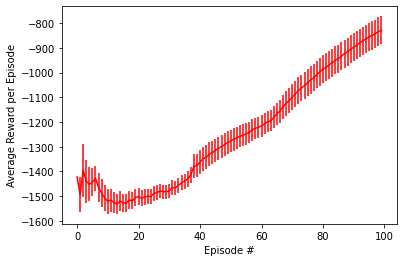

In [10]:
plt.figure()
plt.errorbar(np.arange(np.size(avg_rewards)),avg_rewards,yerr=sem_rewards,color='r')
plt.xlabel("Episode #")
plt.ylabel("Average Reward per Episode")
plt.show()

In [11]:
env.play()

100%|█████████▉| 201/202 [00:00<00:00, 365.82it/s]
